In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import skimage as ski
import cv2

import os

In [2]:
class Object:
    def __init__(self, class_name, img):
        self.class_name = class_name
        self.img = img

In [3]:
H = 256

In [120]:
original_gray_dataset = []

for subdir, _, files in os.walk('dataset'):
    for fname in files:
        class_name = subdir.partition('/')[2]
        img = cv2.imread(f"{subdir}/{fname}", cv2.IMREAD_GRAYSCALE)
        original_gray_dataset.append(Object(class_name, cv2.resize(img, (H, H))))

In [121]:
linear_gradient = np.tile(np.linspace(0,1,H), (H,1))

In [122]:
MEAN_SZ = 3
mean_filter = np.tile(1/(MEAN_SZ**2), (MEAN_SZ, MEAN_SZ))

In [123]:
def augment_img(img):
    return (img,
            cv2.normalize((linear_gradient * img).astype(np.uint8), None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U),
            cv2.normalize((np.log2(1 + img/255) * 255).astype(np.uint8), None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U),
            cv2.normalize(((2**(img/255) - 1) * 255).astype(np.uint8), None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U),
            cv2.filter2D(src=img, ddepth=-1, kernel=mean_filter))

In [124]:
augmented_dataset = []
for obj in original_gray_dataset:
    for aug_img in augment_img(obj.img):        
        augmented_dataset.append(Object(obj.class_name, aug_img))

In [125]:
clahe = cv2.createCLAHE()
normalized_dataset = []
for obj in augmented_dataset:
    normalized_dataset.append(Object(obj.class_name, clahe.apply(obj.img)))

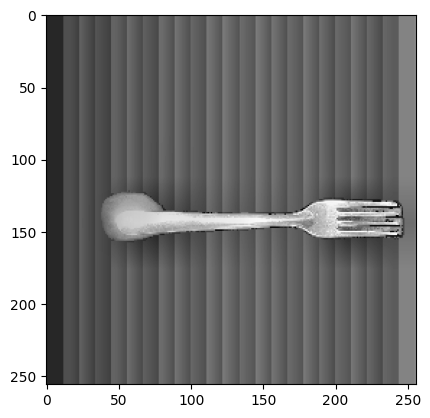

In [223]:
plt.imshow(normalized_dataset[11].img, cmap='gray')
plt.show()

In [127]:
bin_dataset = []
for obj in normalized_dataset:
    _,thresh = cv2.threshold(obj.img,127,255,cv2.THRESH_BINARY)
    bin_dataset.append(Object(obj.class_name, thresh))

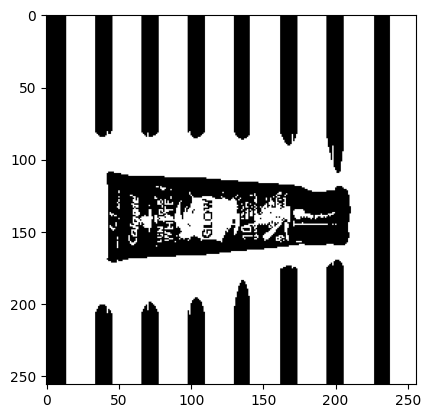

In [216]:
plt.imshow(bin_dataset[111].img, cmap='gray')
plt.show()

In [270]:
edges_dataset = []
for obj in normalized_dataset:
    # edges = cv2.Canny(obj.img,30,100)
    edges = cv2.Canny(cv2.GaussianBlur(obj.img, (5,5), 0), threshold1=255/3, threshold2=255)
    edges_dataset.append(Object(obj.class_name, edges))

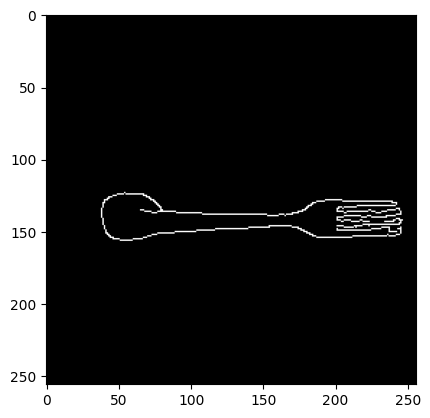

In [271]:
plt.imshow(edges_dataset[11].img, cmap='gray')
plt.show()

In [272]:
contour_dataset = []
for obj in edges_dataset:
    new_img = np.zeros_like(obj.img)
    contour, _ = cv2.findContours(obj.img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnt in contour:
        cv2.drawContours(new_img, [cnt], 0, 255, -1)
    
    rect = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
    dilation = cv2.dilate(new_img, rect, iterations=5)
    erosion = cv2.erode(dilation, rect,  iterations=4)
    dilation = cv2.dilate(erosion, rect, iterations=5)
    erosion = cv2.erode(dilation, rect,  iterations=4)

    contour_dataset.append(Object(obj.class_name, erosion))

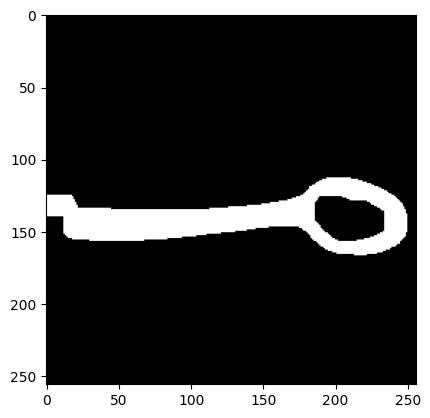

In [273]:
plt.imshow(contour_dataset[444].img, cmap='gray')
plt.show()

In [340]:
seg_dataset = []
objs_per_class = {}

for obj in contour_dataset:
    new_img = np.zeros_like(obj.img)
    contour,hier = cv2.findContours(obj.img,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    
    cnt = max(contour, key=cv2.contourArea)
    cv2.drawContours(new_img, [cnt], 0, 255, -1)

    if not objs_per_class.get(obj.class_name):
        objs_per_class[obj.class_name] = []

    new_obj = Object(obj.class_name, new_img)
    seg_dataset.append(new_obj)
    objs_per_class[obj.class_name].append(new_obj.img.flatten())

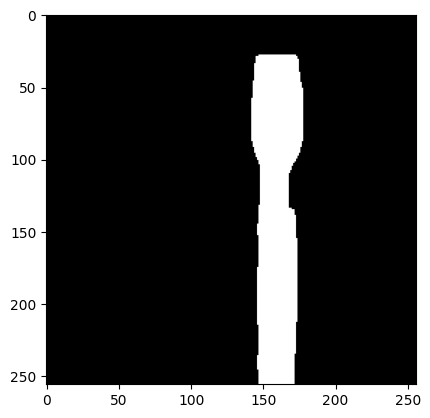

In [335]:
plt.imshow(seg_dataset[36].img, cmap='gray')
plt.show()

In [341]:
from sklearn.model_selection import train_test_split

test_size = 0.2
X_train, X_test, y_train, y_test = [], [], [], []

for class_name in objs_per_class.keys():
    objs = objs_per_class[class_name]
    
    X_tr, X_te, y_tr, y_te = train_test_split(
        objs, 
        [class_name] * len(objs), 
        test_size=test_size, shuffle=True, 
        random_state=42)

    X_train += X_tr
    X_test += X_te
    y_train += y_tr
    y_test += y_te

In [342]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [343]:
X_train

[array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dt

In [344]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [345]:
y_pred = sgd_clf.predict(X_test)

In [346]:
y_pred

array(['Tenis', 'Cosmetico', 'Faca', 'Faca', 'Garfo', 'Cosmetico',
       'Tenis', 'Faca', 'Garfo', 'Tenis', 'Colher', 'Cosmetico', 'Faca',
       'Colher', 'Garfo', 'Garfo', 'Cosmetico', 'Cosmetico', 'Tenis',
       'Faca', 'Colher', 'Faca', 'Colher', 'Cosmetico', 'Cosmetico',
       'Garfo', 'Faca', 'Faca', 'Cosmetico', 'Colher', 'Garfo', 'Faca',
       'Garfo', 'Tenis', 'Tenis', 'Garfo', 'Tenis', 'Cosmetico', 'Garfo',
       'Colher', 'Cosmetico', 'Cosmetico', 'Colher', 'Cosmetico', 'Tenis',
       'Garfo', 'Cosmetico', 'Garfo', 'Garfo', 'Tenis', 'Garfo', 'Colher',
       'Garfo', 'Faca', 'Tenis', 'Colher', 'Colher', 'Faca', 'Tenis',
       'Tenis', 'Tenis', 'Faca', 'Colher', 'Garfo', 'Colher', 'Tenis',
       'Faca', 'Tenis', 'Colher', 'Faca', 'Cosmetico', 'Colher', 'Faca',
       'Faca', 'Colher', 'Tenis', 'Cosmetico', 'Garfo', 'Tenis',
       'Cosmetico', 'Garfo', 'Cosmetico', 'Colher', 'Colher', 'Colher',
       'Cosmetico', 'Faca', 'Faca', 'Garfo', 'Tenis'], dtype='<U9')

In [348]:
np.sum(y_test == y_pred)

90